# Dataset 3 - Boston Housing 

## Parameters

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)
3. prior: 0 (Correct) or 1 (Misspecified) 

In [1]:
#ABC_Generator 
std = 1
mean = 1
prior = 0

## Import Libraries and Dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import statsModel
import sanityChecks
import bostonDataset
import ABC_train_test 
import dataset
import train_test
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from statistics import mean 
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import load_boston
%matplotlib inline

### Dataset


In [4]:
X,Y = bostonDataset.boston_data()
n_features = 13

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  TARGET  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  


## Stats Model
The statistical model is assumed to be $Y=\beta X + \mu$ where $\mu \sim N(0,1)$

To analyze the performance of the statistical model, we plot a graph of $y_{real}$ vs $y_{pred}$ and calculate performance metrics like mean squared error, mean absolute error, manhattan distance and euclidean distance between $y_{real}$ and $y_{pred}$ 

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 07 Oct 2021   Prob (F-statistic):          6.72e-135
Time:                        08:33:20   Log-Likelihood:                -376.55
No. Observations:                 506   AIC:                             781.1
Df Residuals:                     492   BIC:                             840.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.909e-16      0.023  -2.14e-14      1.0

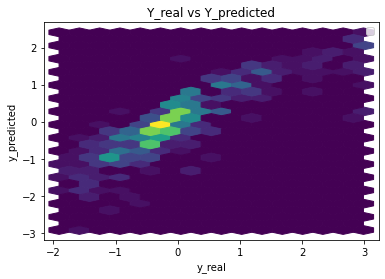

Performance Metrics
Mean Squared Error: 0.2593573358905906
Mean Absolute Error: 0.3559924576478401
Manhattan distance: 180.13218356980715
Euclidean distance: 11.455776357830963


In [5]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Generator and Discriminator Networks 

### Discriminator

In [6]:
class Discriminator(nn.Module):
  def __init__(self,n_input):
    super().__init__()
    self.hidden = nn.Linear(n_input,10)
    self.output = nn.Linear(10,1)
    self.sigmoid = nn.Sigmoid()
    self.leakyRelu = nn.LeakyReLU()

  def forward(self, x):
    x = self.hidden(x)
    x = self.leakyRelu(x)
    x = self.output(x)
    x = self.sigmoid(x)
    return x 

### Generator

In [7]:
class Generator(nn.Module):
  def __init__(self,n_input):
    super().__init__()
    self.output = nn.Linear(n_input,1)

  def forward(self, x):
    x = self.output(x)
    return x 

### ABC Pre Generator

The ABC generator is defined as follows:

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 

$\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else

$\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from stats model

Parameters : $\mu$ and $\sigma^{*}$

$\sigma^{*}$ takes the values 0.01,0.1 and 1

In [8]:
def ABC_pre_generator(x_batch,coeff,variance,mean,device):
    coeff_len = len(coeff)
    if mean == 0:
        weights = np.random.normal(0,variance,size=(coeff_len,1))
        weights = torch.from_numpy(weights).reshape(coeff_len,1)
    else:
        weights = []
        for i in range(coeff_len):
            weights.append(np.random.normal(coeff[i],variance))
        weights = torch.tensor(weights).reshape(coeff_len,1)
    y_abc =  torch.matmul(x_batch,weights.float())
    gen_input = torch.cat((x_batch,y_abc),dim = 1).to(device)
    return gen_input 

## GAN Model

We are using a Conditional GAN network as a baseline. The input to the GAN generator is (X,z) where X are the features of the dataset and z is gaussian noise

In [9]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
generator = Generator(n_features+2)
discriminator = Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))
print(discriminator)
print(generator)

Discriminator(
  (hidden): Linear(in_features=15, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (leakyRelu): LeakyReLU(negative_slope=0.01)
)
Generator(
  (output): Linear(in_features=15, out_features=1, bias=True)
)


In [11]:
sample_size = len(real_dataset)
n_epochs = 15000
batch_size = sample_size

In [ ]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

In [ ]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

In [ ]:
gen = Generator(n_features+2)
disc = Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [ ]:
n_epoch_abc = 2000
batch_size = sample_size

In [ ]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epoch_abc,criterion,coeff,mean,std,device)

In [ ]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,std,device)

### Sanity Check 

We plot the discriminator output vs the noise in the input to verify that the discriminator functions correctly. We expect that discriminator output and noise are inversely proportional

In [ ]:
sanityChecks.discProbVsError(real_dataset,disc,device)

### Visualization of Trained GAN Generator

In [ ]:
for name, param in gen.named_parameters():
    print(name,param)